In [1]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

In [2]:
import scienceplots

plt.style.use(['bright', 'science', 'no-latex', 'notebook'])

### Read the BPT valley sources

In [3]:
table2a = ascii.read('table2.txt', data_start=5, data_end=13, header_start=2, delimiter='\t')
table2b = ascii.read('table2.txt', data_start=14, data_end=19, header_start=2, delimiter='\t')

table2 = table.vstack([table2a, table2b])

In [4]:
table1 = ascii.read('table1.txt', data_start=3, data_end=73, header_start=2, delimiter='\t')

In [5]:
data_agn = table.join(table1, table2, join_type='inner')
cat_agn = concatenate([SkyCoord.from_name(d.split(' ')[1]) for d in data_agn['SDSS Name']])
data_agn # len=13

ID,SDSS Name,Plate,MJD,Fiber,z,Hbetalambda4861,[O III]lambda5007,[O I]lambda6300,Halphalambda6563,[N II]lambda6584,$f{({\rm{H}}\alpha )}_{{\rm{n}}}$,$f{({\rm{H}}\alpha )}_{{\rm{b}}}$,${\mathrm{FWHM}}_{{\rm{H}}\alpha }$,${\mathrm{FWHM}}_{[{\rm{S}}{\rm{II}}]}$,${\mathrm{EW}}_{\mathrm{rest}}{({\rm{H}}\alpha )}_{{\rm{b}}}$
int64,str24,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3,SDSS J230321.73+011056.4,380,51792,565,0.18136,235.38,1692.71,12.29,816.35,247.33,991.96,1834.96,7162.24,245.05,88.1
8,SDSS J090613.76+561015.1,483,51902,16,0.04668,188.36,1144.93,73.96,621.46,189.46,414.2,309.7,875.81,247.31,27.02
12,SDSS J001050.35-010257.4,686,52519,20,0.11299,223.89,1669.57,109.74,940.89,275.9,524.87,830.66,1682.7,324.79,57.25
13,SDSS J124738.52+621243.1,781,52373,76,0.12112,171.82,915.8,33.03,697.15,162.91,748.78,728.55,2033.36,223.68,72.83
17,SDSS J104600.36+061632.0,1000,52643,35,0.18447,146.67,637.74,31.28,586.86,177.72,719.07,392.29,3396.57,270.94,44.74
21,SDSS J081653.27+285423.1,1206,52670,530,0.0574,246.45,1610.19,131.99,1145.34,203.6,1014.89,1145.11,2440.19,337.97,44.13
25,SDSS J124110.10+104143.7,1233,52734,611,0.15613,214.49,1004.84,29.37,703.65,188.71,607.56,930.7,1974.28,248.66,159.88
34,SDSS J121839.40+470627.6,1451,53117,190,0.09389,478.35,5046.81,101.68,1861.68,380.45,2072.41,797.1,2083.37,377.39,33.06
47,SDSS J120847.79+135906.7,1764,53467,13,0.2903,136.33,659.31,28.11,554.94,137.92,515.66,726.01,3569.9,273.99,246.77


In [6]:
data_agn.columns

<TableColumns names=('ID','SDSS Name','Plate','MJD','Fiber','z','Hbetalambda4861','[O III]lambda5007','[O I]lambda6300','Halphalambda6563','[N II]lambda6584','$f{({\rm{H}}\alpha )}_{{\rm{n}}}$','$f{({\rm{H}}\alpha )}_{{\rm{b}}}$','${\mathrm{FWHM}}_{{\rm{H}}\alpha }$','${\mathrm{FWHM}}_{[{\rm{S}}{\rm{II}}]}$','${\mathrm{EW}}_{\mathrm{rest}}{({\rm{H}}\alpha )}_{{\rm{b}}}$')>

In [7]:
cat_agn.dec.deg

array([ 1.18234, 56.17087, -1.04928, 62.21198,  6.27556, 28.90642,
       10.69548, 47.10767, 13.9852 , 21.1892 , 11.24931, 15.3974 ,
       24.36498])

### Read Mingyang's result

In [8]:
data_mingyang = ascii.read('match.csv')
data_mingyang

ID,SDSS,Name,Plate,MJD,Fiber,z,Hbeta,OIII5007,OI6300,Halpha,NII6584,RA_1,DEC_1,Index,RA_2,DEC_2,logLbol,logLbol_e,Morph,logMBH,logEdd,logMs,logMs_e
int64,str4,str19,int64,int64,int64,float64,float64,float64,float64,float64,float64,str11,str11,int64,float64,float64,float64,float64,str10,float64,float64,float64,float64
3,SDSS,J230321.73+011056.4,380,51792,565,0.18136,235.38,1692.71,12.29,816.35,247.33,23 03 21.73,+01 10 56.4,14367,345.84052,1.1823265,44.57,0.01,Early,8.81,-2.34,11.25,0.07
13,SDSS,J124738.52+621243.1,781,52373,76,0.12112,171.82,915.8,33.03,697.15,162.91,12 47 38.52,+62 12 43.1,7988,191.91051,62.211974,43.93,0.01,Unreliable,6.8,-0.98,9.92,0.19
21,SDSS,J081653.27+285423.1,1206,52670,530,0.0574,246.45,1610.19,131.99,1145.34,203.6,08 16 53.27,+28 54 23.1,1429,124.22198,28.906405,43.61,0.0,Late,6.61,-1.1,10.31,0.11
25,SDSS,J124110.10+104143.7,1233,52734,611,0.15613,214.49,1004.84,29.37,703.65,188.71,12 41 10.10,+10 41 43.7,7809,190.29209,10.695466,44.2,0.05,Early,7.1,-0.99,9.88,0.09
26,SDSS,J092620.42+352250.3,1274,52995,147,0.24729,118.98,868.18,81.24,513.89,75.74,09 26 20.42,+35 22 50.3,3003,141.58512,35.380659,44.12,0.06,Early,7.86,-1.84,10.4,0.13
34,SDSS,J121839.40+470627.6,1451,53117,190,0.09389,478.35,5046.81,101.68,1861.68,380.45,12 18 39.40,+47 06 27.6,7259,184.66417,47.107684,43.81,0.02,Early,6.83,-1.12,10.75,0.11
40,SDSS,J135855.82+493414.1,1670,53438,61,0.11592,56.67,385.56,14.74,189.76,50.29,13 58 55.82,+49 34 14.1,9818,209.73263,49.570602,44.0,0.01,Early,7.38,-1.47,10.58,0.13
58,SDSS,J145505.97+211121.1,2148,54526,122,0.06751,82.3,441.8,12.31,437.94,126.61,14 55 05.97,+21 11 21.1,11242,223.77489,21.189205,43.45,0.01,Early,6.3,-0.95,10.67,0.09
65,SDSS,J084658.44+111457.5,2574,54084,382,0.06296,130.82,638.15,41.04,557.91,161.29,08 46 58.44,+11 14 57.5,2055,131.74351,11.249321,43.35,0.01,Early,7.12,-1.87,10.03,0.12


### Download and fit the SDSS spectra

Create parameter file

In [9]:
"""
Create parameter file
lambda    complexname  minwav maxwav linename ngauss inisca minsca maxsca inisig minsig maxsig voff vindex windex findex fvalue vary
"""

lw_na_min = 0.0017/10
lw_na_ini = 1e-3

newdata = np.rec.array([
(6564.61, r'H$\alpha$', 6400, 6800, 'Ha_br',   1, 0.1, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.005, 0, 0, 0, 0.05 , 1),
(6564.61, r'H$\alpha$', 6400, 6800, 'Ha_na',   1, 0.1, 0.0, 1e10, 1e-3, 5e-4,   lw_na_min, lw_na_ini,  1, 1, 0, 0.002, 1),
(6549.85, r'H$\alpha$', 6400, 6800, 'NII6549', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, lw_na_min, lw_na_ini,  1, 1, 1, 0.001, 1),
(6585.28, r'H$\alpha$', 6400, 6800, 'NII6585', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, lw_na_min, lw_na_ini,  1, 1, 1, 0.003, 1),
(6718.29, r'H$\alpha$', 6400, 6800, 'SII6718', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, lw_na_min, lw_na_ini,  1, 1, 2, 0.001, 1),
(6732.67, r'H$\alpha$', 6400, 6800, 'SII6732', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, lw_na_min, lw_na_ini,  1, 1, 2, 0.001, 1),

(4862.68, r'H$\beta$', 4640, 5100, 'Hb_br',     1, 0.1, 0.0, 1e10, 5e-3, 0.004,  0.01,   0.01, 0, 0, 0, 0.01 , 1),
(4862.68, r'H$\beta$', 4640, 5100, 'Hb_na',     1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, lw_na_min, 0.01, 1, 1, 0, 0.002, 1),
(4960.30, r'H$\beta$', 4640, 5100, 'OIII4959c', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, lw_na_min, 0.01, 1, 1, 0, 0.002, 1),
(5008.24, r'H$\beta$', 4640, 5100, 'OIII5007c', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, lw_na_min, 0.01/2, 1, 1, 0, 0.004, 1),
#(4960.30, r'H$\beta$', 4640, 5100, 'OIII4959w',   1, 0.1, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.001, 1),
#(5008.24, r'H$\beta$', 4640, 5100, 'OIII5007w',   1, 0.1, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.002, 1),
#(4687.02, r'H$\beta$', 4640, 5100, 'HeII4687_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.005, 0, 0, 0, 0.001, 1),
(4687.02, r'H$\beta$', 4640, 5100, 'HeII4687_na', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, lw_na_min, 0.005, 1, 1, 0, 0.001, 1),
        
(4341.68, r'H$\gamma$', 4640, 5100, 'Hg', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, lw_na_min, 0.005, 1, 1, 0, 0.001, 1),

(3934.78, 'CaII', 3900, 3960, 'CaII3934' , 2, 0.1, 0.0, 1e10, 1e-3, 3.333e-4, 0.0017, 0.01, 99, 0, 0, -0.001, 1),

(3728.48, 'OII', 3650, 3800, 'OII3728', 1, 0.1, 0.0, 1e10, 1e-3, 3.333e-4, lw_na_min, 0.01, 1, 1, 0, 0.001, 1),
    
#(3426.84, 'NeV', 3380, 3480, 'NeV3426',    1, 0.1, 0.0, 1e10, 1e-3, 3.333e-4, 0.0017, 0.01, 0, 0, 0, 0.001, 1),
#(3426.84, 'NeV', 3380, 3480, 'NeV3426_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.0025,   0.02,   0.01, 0, 0, 0, 0.001, 1),

#(2798.75, 'MgII', 2700, 2900, 'MgII_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
#(2798.75, 'MgII', 2700, 2900, 'MgII_na', 2, 0.1, 0.0, 1e10, 1e-3, 5e-4, 0.0017, 0.01, 1, 1, 0, 0.002, 1),

#(1908.73, 'CIII', 1700, 1970, 'CIII_br',   2, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 99, 0, 0, 0.01, 1),
#(1908.73, 'CIII', 1700, 1970, 'CIII_na',   1, 0.1, 0.0, 1e10, 1e-3, 5e-4,  0.0017, 0.01,  1, 1, 0, 0.002, 1),
#(1892.03, 'CIII', 1700, 1970, 'SiIII1892', 1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
#(1857.40, 'CIII', 1700, 1970, 'AlIII1857', 1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
#(1816.98, 'CIII', 1700, 1970, 'SiII1816',  1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
#(1786.7,  'CIII', 1700, 1970, 'FeII1787',  1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
#(1750.26, 'CIII', 1700, 1970, 'NIII1750',  1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),
#(1718.55, 'CIII', 1700, 1900, 'NIV1718',   1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),

#(1549.06, 'CIV', 1500, 1700, 'CIV_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05,   0.015, 0, 0, 0, 0.05 , 1),
#(1549.06, 'CIV', 1500, 1700, 'CIV_na', 1, 0.1, 0.0, 1e10, 1e-3, 5e-4,  0.0017, 0.01,  1, 1, 0, 0.002, 1),
#(1640.42, 'CIV', 1500, 1700, 'HeII1640',    1, 0.1, 0.0, 1e10, 1e-3, 5e-4,   0.0017, 0.008, 1, 1, 0, 0.002, 1),
#(1663.48, 'CIV', 1500, 1700, 'OIII1663',    1, 0.1, 0.0, 1e10, 1e-3, 5e-4,   0.0017, 0.008, 1, 1, 0, 0.002, 1),
#(1640.42, 'CIV', 1500, 1700, 'HeII1640_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),
#(1663.48, 'CIV', 1500, 1700, 'OIII1663_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),

#(1402.06, 'SiIV', 1290, 1450, 'SiIV_OIV1', 1, 0.1, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
#(1396.76, 'SiIV', 1290, 1450, 'SiIV_OIV2', 1, 0.1, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
#(1335.30, 'SiIV', 1290, 1450, 'CII1335',   1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),
#(1304.35, 'SiIV', 1290, 1450, 'OI1304',    1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),

(1215.67, 'Lya', 1150, 1290, 'Lya_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05,   0.02, 0, 0, 0, 0.05 , 1),
(1215.67, 'Lya', 1150, 1290, 'Lya_na', 1, 0.1, 0.0, 1e10, 1e-3, 5e-4,  0.0017, 0.01, 0, 0, 0, 0.002, 1)],

formats = 'float32,      a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32,   float32, int32',
names  =  ' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,  voff,     vindex, windex,  findex,  fvalue,  vary')

# Header
hdr = fits.Header()
hdr['lambda'] = 'Vacuum Wavelength in Ang'
hdr['minwav'] = 'Lower complex fitting wavelength range'
hdr['maxwav'] = 'Upper complex fitting wavelength range'
hdr['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr['inisca'] = 'Initial guess of line scale [flux]'
hdr['minsca'] = 'Lower range of line scale [flux]'
hdr['maxsca'] = 'Upper range of line scale [flux]'

hdr['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr['minsig'] = 'Lower range of line sigma [lnlambda]'  
hdr['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr['vary'] = 'Whether or not to vary the line parameters (set to 0 to fix the line parameters to initial values)'

# Save line info
hdu = fits.BinTableHDU(data=newdata, header=hdr, name='data')
hdu.writeto(os.path.join('', 'qsopar.fits'), overwrite=True)

In [10]:
table.Table(newdata)

lambda,compname,minwav,maxwav,linename,ngauss,inisca,minsca,maxsca,inisig,minsig,maxsig,voff,vindex,windex,findex,fvalue,vary
float32,bytes20,float32,float32,bytes20,int32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,float32,int32
6564.61,H$\alpha$,6400.0,6800.0,Ha_br,1,0.1,0.0,10000000000.0,0.005,0.004,0.05,0.005,0,0,0,0.05,1
6564.61,H$\alpha$,6400.0,6800.0,Ha_na,1,0.1,0.0,10000000000.0,0.001,0.0005,0.00017,0.001,1,1,0,0.002,1
6549.85,H$\alpha$,6400.0,6800.0,NII6549,1,0.1,0.0,10000000000.0,0.001,0.00023,0.00017,0.001,1,1,1,0.001,1
6585.28,H$\alpha$,6400.0,6800.0,NII6585,1,0.1,0.0,10000000000.0,0.001,0.00023,0.00017,0.001,1,1,1,0.003,1
6718.29,H$\alpha$,6400.0,6800.0,SII6718,1,0.1,0.0,10000000000.0,0.001,0.00023,0.00017,0.001,1,1,2,0.001,1
6732.67,H$\alpha$,6400.0,6800.0,SII6732,1,0.1,0.0,10000000000.0,0.001,0.00023,0.00017,0.001,1,1,2,0.001,1
4862.68,H$\beta$,4640.0,5100.0,Hb_br,1,0.1,0.0,10000000000.0,0.005,0.004,0.01,0.01,0,0,0,0.01,1
4862.68,H$\beta$,4640.0,5100.0,Hb_na,1,0.1,0.0,10000000000.0,0.001,0.00023,0.00017,0.01,1,1,0,0.002,1
4960.3,H$\beta$,4640.0,5100.0,OIII4959c,1,0.1,0.0,10000000000.0,0.001,0.00023,0.00017,0.01,1,1,0,0.002,1


Fit

In [11]:
#data[3].header

J230321.73+011056.4
       ra              dec               objid        ... run2d instrument
---------------- ---------------- ------------------- ... ----- ----------
345.840548435589 1.18236004595278 1237678617411649632 ...    26       SDSS
[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fc71901ec10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fc719025890>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fc718fdb090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fc718fe2b10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fc72027fdd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fc718f95410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fc718f2d150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fc718f43e50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fc718f5bb90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fc718ef3890>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fc718f0b5d0>, <astropy.io.fits.hdu.table.B

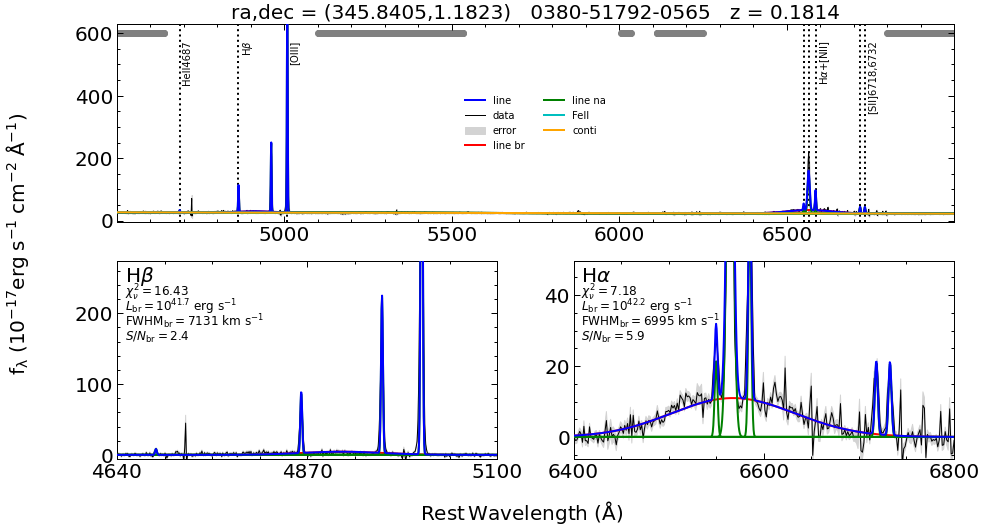

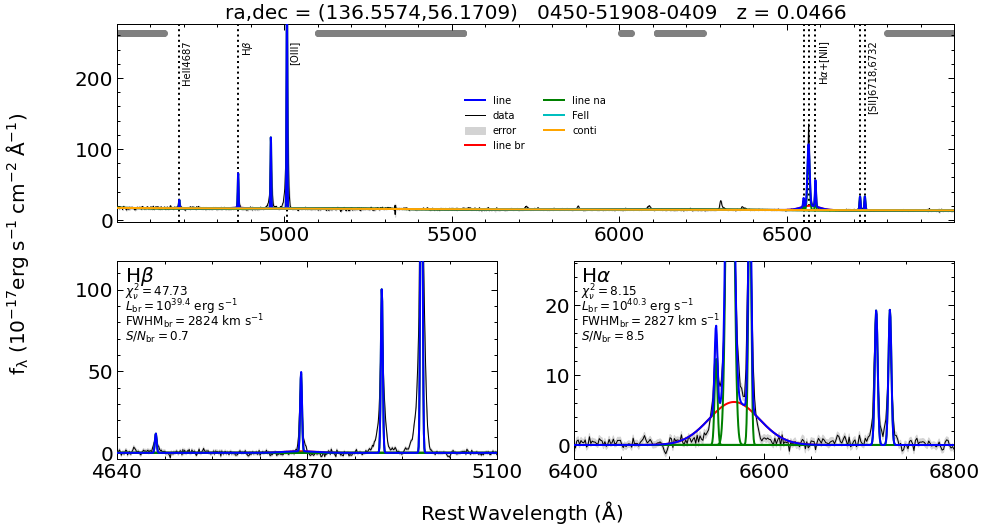

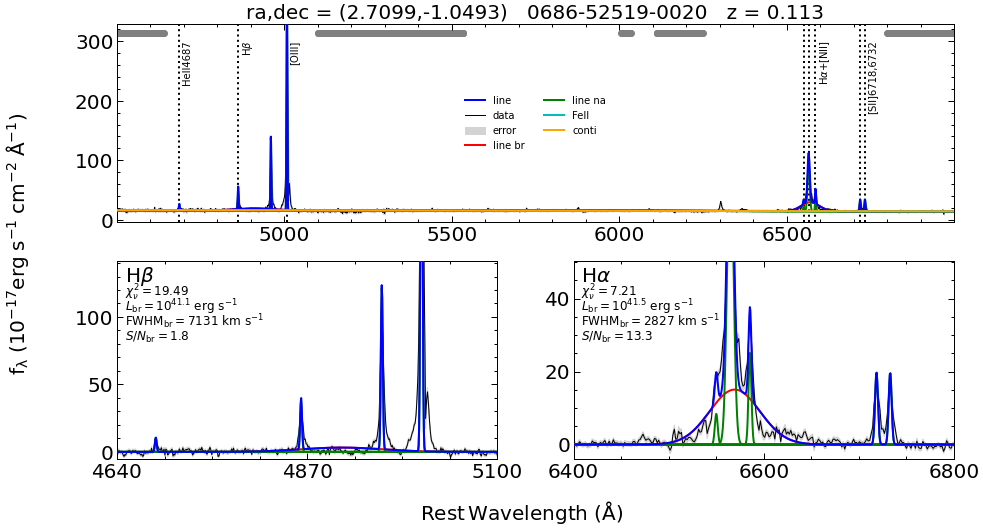

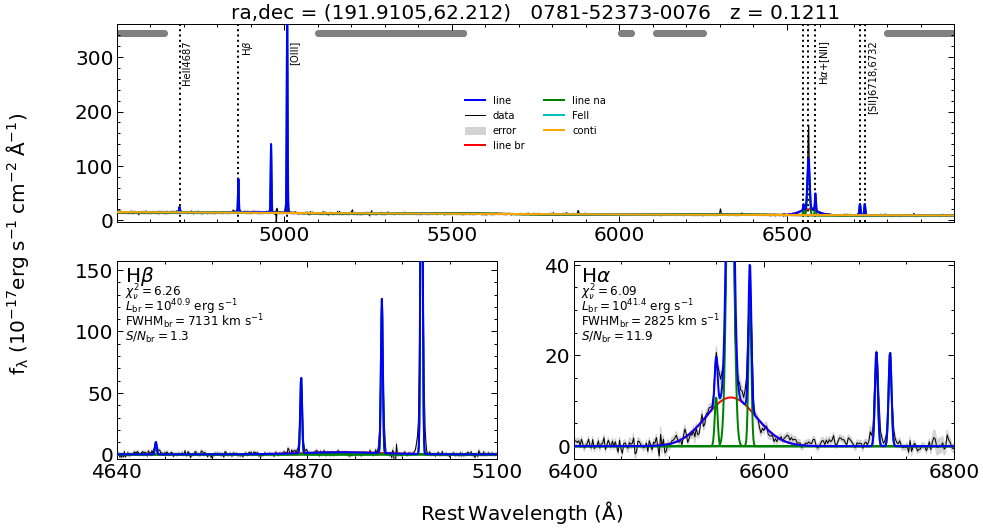

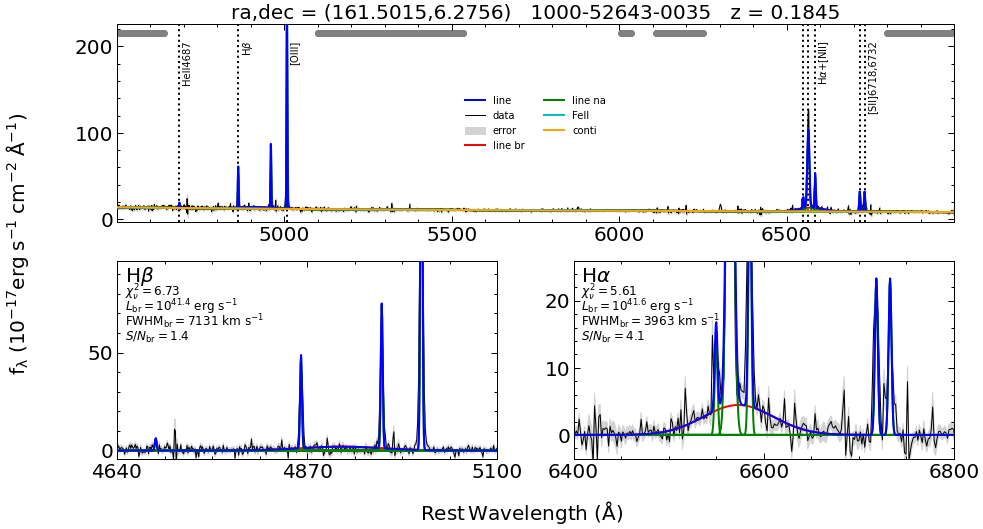

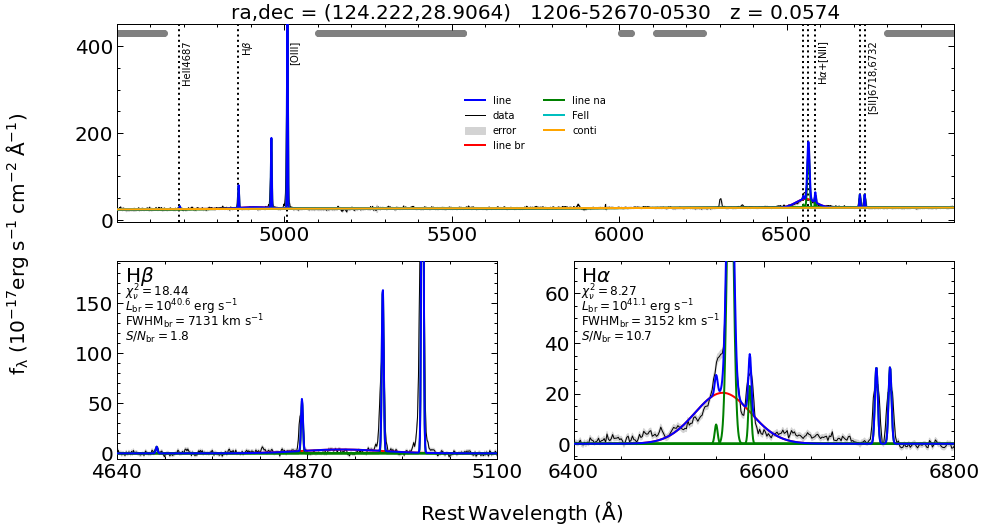

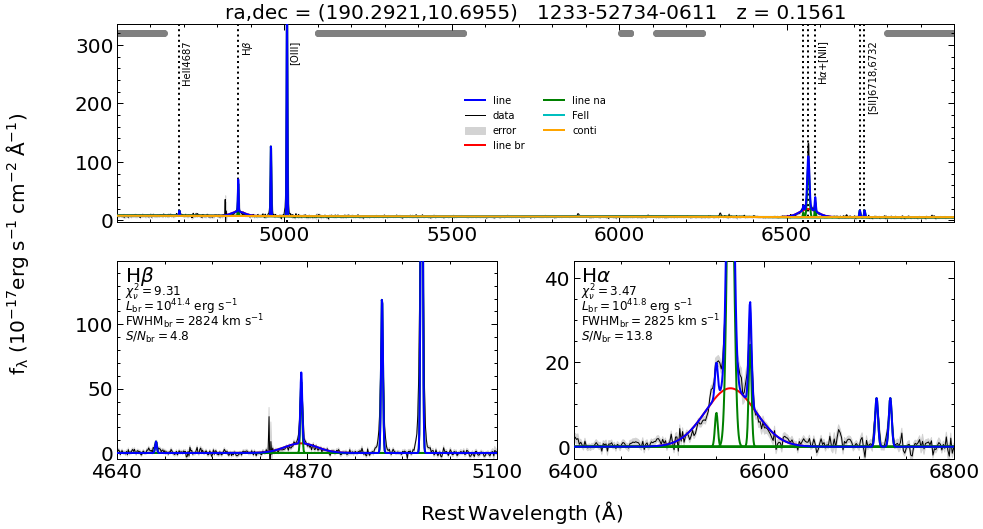

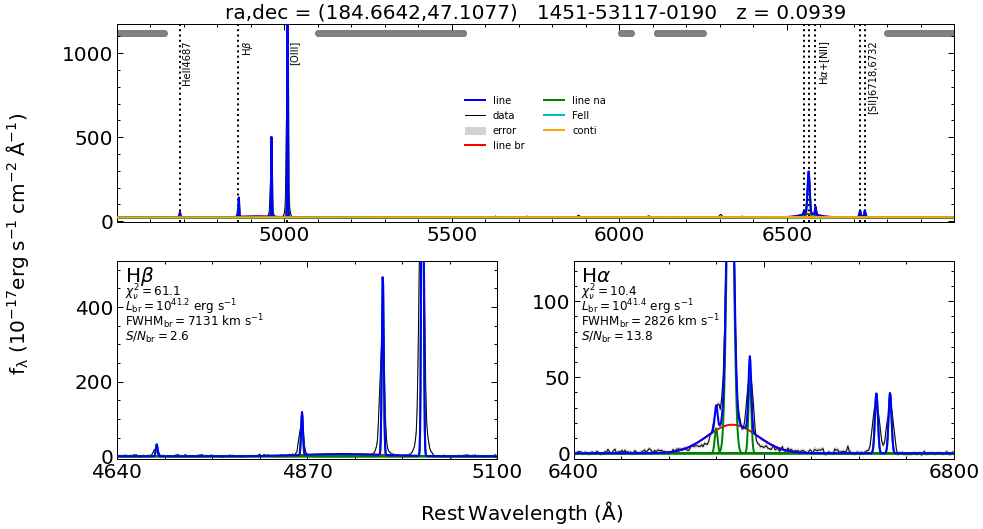

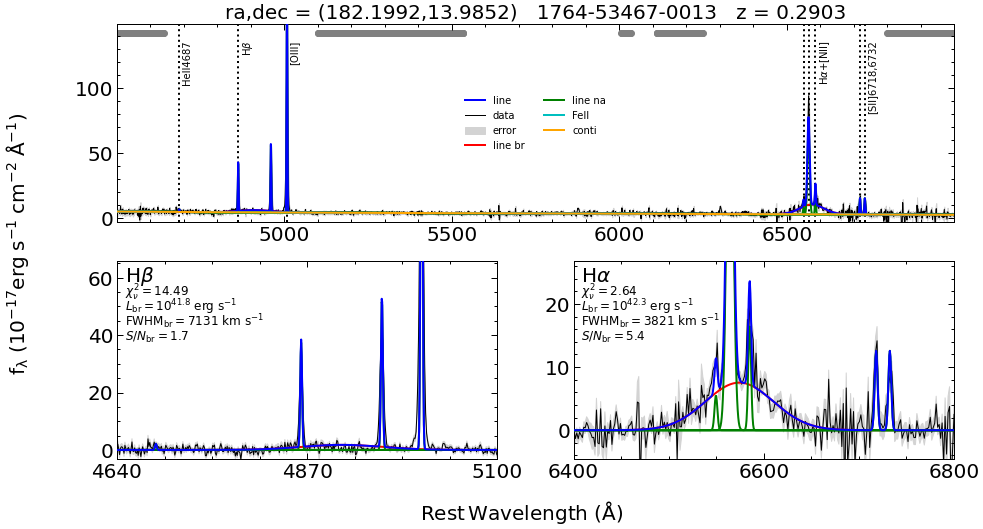

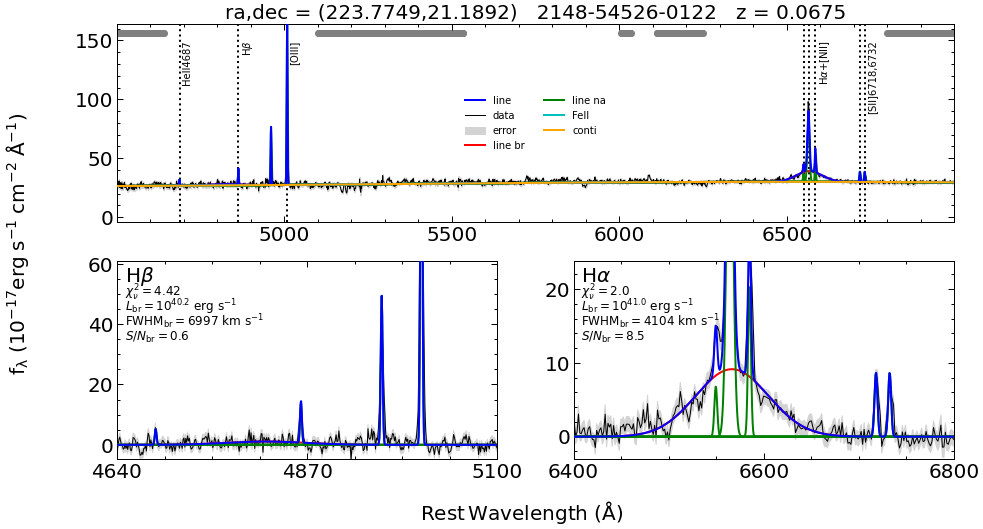

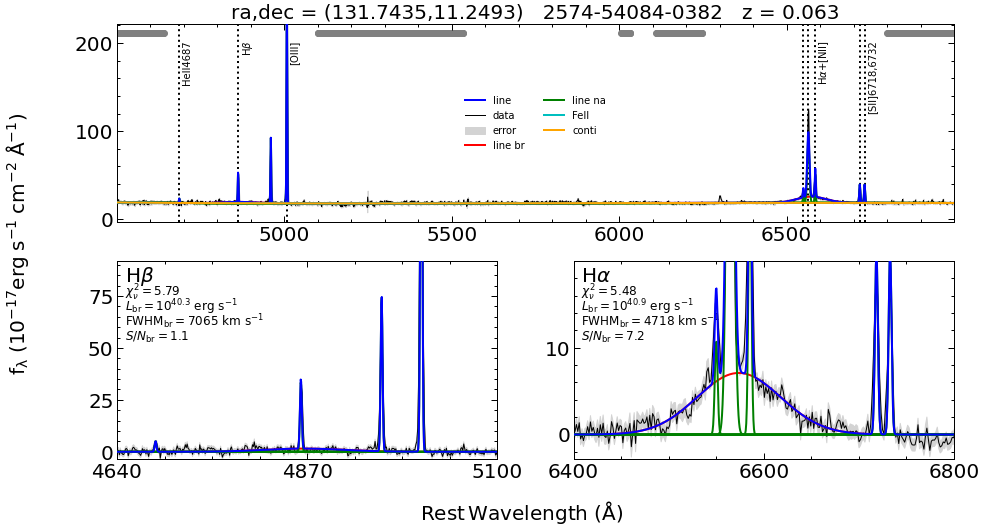

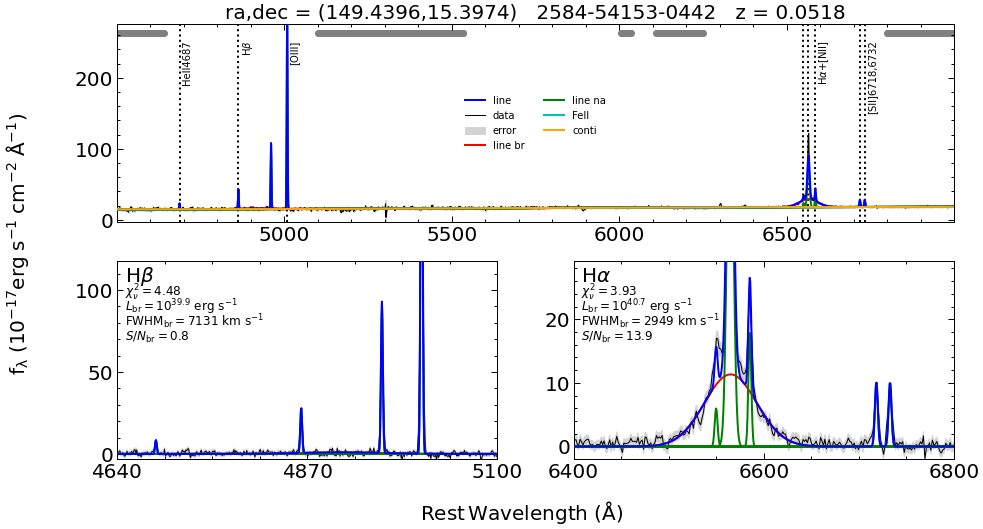

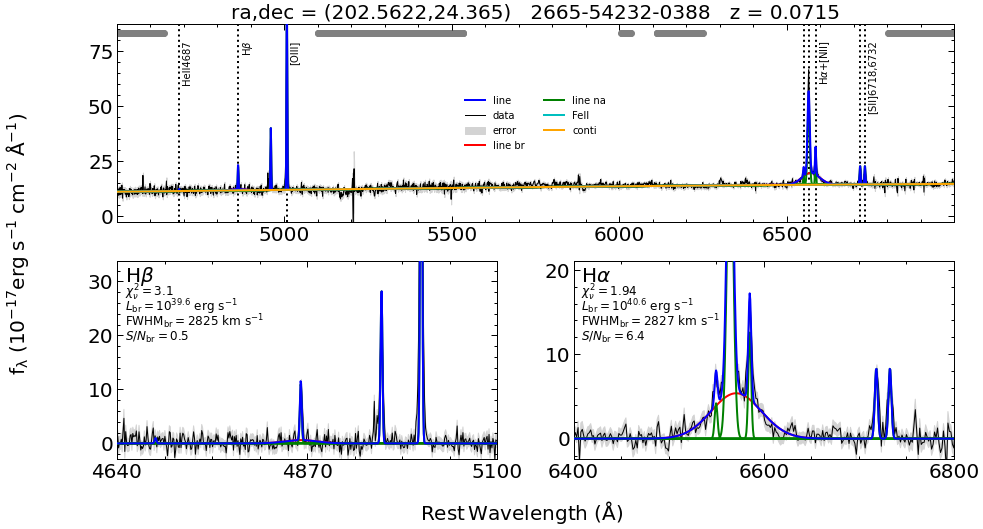

In [12]:
from astroquery.sdss import SDSS
from pyqsofit.PyQSOFit import QSOFit

_12pluslogOHs = np.zeros(len(data_agn))
M_BHs = np.zeros(len(data_agn))

mags = []

for i, row in enumerate(data_agn):
    
    print(data_agn['SDSS Name'][i][5:])

    # Query the spectrum
    pos = SkyCoord.from_name(data_agn['SDSS Name'][i][5:])
    xid = SDSS.query_region(pos, spectro=True)
    print(xid)
    sp = SDSS.get_spectra(matches=xid)
    print(sp)
    data = sp[0]
    
    r = SDSS.query_crossid(pos, photoobj_fields=['modelMag_g','modelMag_r','modelMag_i'])
    mags.append(r)
    print(r)

    # Fit the spectrum
    path_out = ''

    # Requried
    lam = 10**data[1].data['loglam']        # OBS wavelength [A]
    flux = data[1].data['flux']             # OBS flux [erg/s/cm^2/A]
    err = 1/np.sqrt(data[1].data['ivar'])   # 1 sigma error
    z = data[2].data['z'][0]                # Redshift


    # Optional
    ra = data[0].header['plug_ra']        # RA
    dec = data[0].header['plug_dec']      # DEC
    plateid = data[0].header['plateid']   # SDSS plate ID
    mjd = data[0].header['mjd']           # SDSS MJD
    fiberid = data[0].header['fiberid']   # SDSS fiber ID

    # Prepare data
    q_mle = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path='')

    # Double check the installation path with the PCA / Fe template files
    print('install path:', q_mle.install_path)
    # Change it if you installed them somewhere else
    #q_mle.install_path = '/home/colinjb2/.conda/envs/pypeit/lib/python3.9/site-packages/pyqsofit'

    # Do the fitting
    q_mle.fit(nsmooth=1, deredden=True, reject_badpix=False, wave_range=np.array([4500,7000]), \
              wave_mask=None, decompose_host=False, BC03=False, npca_gal=5, npca_qso=10, Fe_uv_op=False, \
              poly=True, BC=False, linefit=True, save_result=True, \
              kwargs_plot={'save_fig_path':'.', 'broad_fwhm':1200}, save_fits_path='', verbose=False)

    # Extract BH mass and metallicity using the method of
    # Carvalho et al. (2020)

    fwhm_NII, sigma_NII, ew_NII, peak_NII, area_NII, snr_NII = q_mle.line_prop_from_name('NII6585', 'narrow')

    fwhm_Ha_na, sigma_Ha_na, ew_Ha_na, peak_Ha_na, area_Ha_na, snr_Ha_na = q_mle.line_prop_from_name('Ha_na', 'narrow')

    N2 = np.log10(area_NII/area_Ha_na)
    z = 4.01**N2 - 0.07
    print(z) # valid for z = 0.3 - 2

    _12pluslogOHs[i] =  12 + (np.log10(z * 10**-3.31))
    _12pluslogOH_Sun = 12 + -3.31 # 8.69
    
    print('12 + logO/H = ', _12pluslogOHs[i])
    print('Z = ', _12pluslogOHs[i]/_12pluslogOH_Sun)
    
    # BH mass
    fwhm_Ha_br, sigma_Ha_br, ew_Ha_br, peak_Ha_br, area_Ha_br, snr_Ha_br = q_mle.line_prop_from_name('Ha_br', 'broad')
    
    M_BHs[i] = 2.4*1e6 * (q_mle.flux2L(area_Ha_br)/1e42)**0.59 * (fwhm_Ha_br/1e3)**2.0
    
    print('M_BH = ', np.log10(M_BHs[i]))
    print('..........................................................')
    

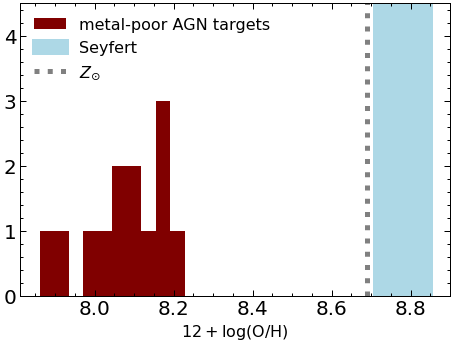

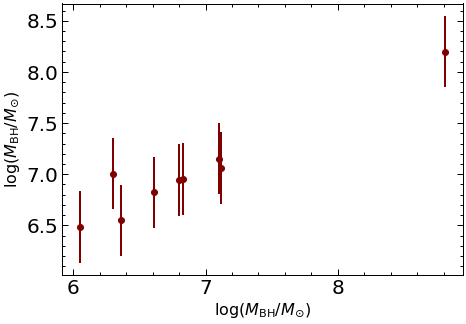

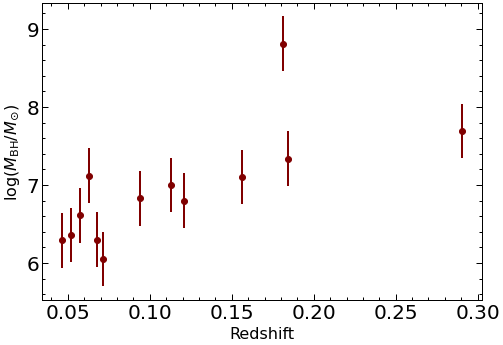

In [152]:
data_agn['12+logO/H'] = _12pluslogOHs

fig, ax = plt.subplots(1,1, figsize=(6.5,5))
ax.hist(data_agn['12+logO/H'], color='maroon', label='metal-poor AGN targets')

ax.axvspan(8.71, 8.85, lw=5, color='lightblue', label='Seyfert')
ax.vlines(8.69, 0, 6, lw=5, color='gray', linestyle='dotted', label=r'$Z_{\odot}$')


ax.set_ylim([0, 4.5])

ax.set_xlabel(r'$12 + \log($O$/$H$)$')
ax.legend()
fig.tight_layout()
fig.savefig('metallicity.pdf', dpi=300)
# https://arxiv.org/pdf/2203.08602.pdf

# Use Mingyang's BH masses when available (why the descrepency?)
cat_mingyang = concatenate([SkyCoord.from_name(d) for d in data_mingyang['Name']])
cat_mingyang = SkyCoord(cat_mingyang.ra, cat_mingyang.dec, unit='deg')

idx_agn,idx_mingyang,d2d,d3d = cat_mingyang.search_around_sky(cat_agn, 1*u.arcsec)


fig, ax = plt.subplots(1,1, figsize=(7.2,5))
ax.errorbar(data_mingyang['logMBH'][idx_mingyang], np.log10(M_BHs[idx_agn]), yerr=0.35, linestyle='none', marker='o', color='maroon')
ax.set_xlabel(r'$\log(M_{\rm{BH}}/M_{\odot})$')
ax.set_ylabel(r'$\log(M_{\rm{BH}}/M_{\odot})$')


M_BHs[idx_agn] = 10**data_mingyang['logMBH'][idx_mingyang]


data_agn['M_BH'] = M_BHs

fig, ax = plt.subplots(1,1, figsize=(7.2,5))
ax.errorbar(data_agn['z'], np.log10(M_BHs), yerr=0.35, linestyle='none', marker='o', color='maroon')
ax.set_ylabel(r'$\log(M_{\rm{BH}}/M_{\odot})$')
ax.set_xlabel(r'Redshift')

fig.tight_layout()
fig.savefig('bh_mass.pdf', dpi=300)

In [178]:
i = [m['modelMag_i'][0] for m in mags]

data_agn_latex = table.Table([data_agn['SDSS Name'], data_agn['z'], np.around(data_agn['12+logO/H'],1), np.around(np.log10(M_BHs),1), np.around(i,1)])
data_agn_latex
ascii.write(data_agn_latex, format='latex')

\begin{table}
\begin{tabular}{ccccc}
SDSS Name & z & col2 & col3 & col4 \\
SDSS J230321.73+011056.4 & 0.18136 & 8.2 & 8.2 & 17.2 \\
SDSS J090613.76+561015.1 & 0.04668 & 8.2 & 6.3 & 17.1 \\
SDSS J001050.35-010257.4 & 0.11299 & 8.1 & 7.0 & 17.0 \\
SDSS J124738.52+621243.1 & 0.12112 & 8.1 & 6.9 & 18.0 \\
SDSS J104600.36+061632.0 & 0.18447 & 8.2 & 7.3 & 18.2 \\
SDSS J081653.27+285423.1 & 0.0574 & 7.9 & 6.8 & 16.2 \\
SDSS J124110.10+104143.7 & 0.15613 & 8.0 & 7.2 & 18.5 \\
SDSS J121839.40+470627.6 & 0.09389 & 7.9 & 7.0 & 16.4 \\
SDSS J120847.79+135906.7 & 0.2903 & 8.0 & 7.7 & 19.4 \\
SDSS J145505.97+211121.1 & 0.06751 & 8.2 & 7.0 & 16.1 \\
SDSS J084658.44+111457.5 & 0.06296 & 8.2 & 7.1 & 17.2 \\
SDSS J095745.49+152350.6 & 0.05183 & 8.0 & 6.5 & 16.6 \\
SDSS J133014.91+242153.9 & 0.07151 & 8.1 & 6.5 & 16.8 \\
\end{tabular}
\end{table}


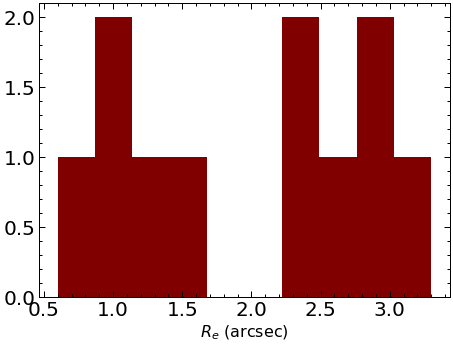

In [176]:
Re = [1.5, 0.6, 2.4, 0.9, 1.2, 2.8, 3.3, 2.7, 0.9, 2.4, 3.0] # r radii
fig, ax = plt.subplots(1,1, figsize=(6.5,5))
ax.hist(Re, color='maroon', label='metal-poor AGN targets')
ax.set_xlabel(r'$R_e$ (arcsec)')

fig.tight_layout()
fig.savefig('Re.pdf', dpi=300)

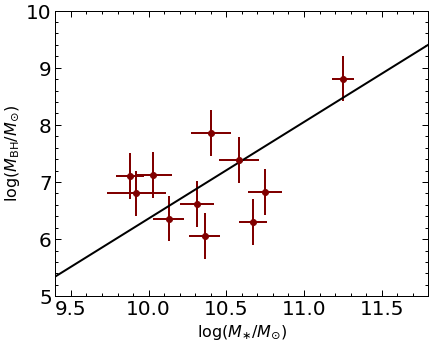

In [127]:
fig, ax = plt.subplots(1,1, figsize=(6.2,5))
ax.errorbar(data_mingyang['logMs'], data_mingyang['logMBH'], yerr=0.4, xerr=data_mingyang['logMs_e'],
            linestyle='none', marker='o', color='maroon')
ax.set_ylabel(r'$\log(M_{\rm{BH}}/M_{\odot})$')
ax.set_xlabel(r'$\log(M_{\ast}/M_{\odot})$')

x = np.linspace(9, 12)
y = 1.69 * (x-11) + 8.05

ax.plot(x, y, color='k')
ax.set_xlim(9.4, 11.8)
ax.set_ylim(5, 10)

fig.tight_layout()
fig.savefig('mbh_mstar.pdf', dpi=300)

In [ ]:
# NEW WAY: using line_prop_from_name convenience function
fwhm, sigma, ew, peak, area, snr = q_mle.line_prop_from_name('Ha_br', 'broad')

print("Broad Ha:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))
print("")

fwhm_NII, sigma_NII, ew_NII, peak_NII, area_NII, snr_NII = q_mle.line_prop_from_name('NII6585', 'narrow')

fwhm_Ha_na, sigma_Ha_na, ew_Ha_na, peak_Ha_na, area_Ha_na, snr_Ha_na = q_mle.line_prop_from_name('Ha_na', 'narrow')

N2 = np.log10(area_NII/area_Ha_na)
z = 4.01**N2 - 0.07
print(z) # valid for z = 0.3 - 2

_12pluslogOH = 12 + (np.log10(z * 10**-3.31))
_12pluslogOH_Sun = 12 + -3.31 # 8.69
print(_12pluslogOH_Sun)

print('12 + logO/H = ', _12pluslogOH)
print('Z = ', _12pluslogOH/_12pluslogOH_Sun)